In [53]:
try:
    # Cell 1: Import necessary libraries
    import os
    import glob
    import pandas as pd

    import matplotlib.pyplot as plt
    import seaborn as sns

    from sklearn.cluster import KMeans
    from kneed import KneeLocator
    from sklearn.metrics import silhouette_score


except Exception as e:
    print(f"Error : {e}")

In [54]:
# Cell 2: Load the dataset
# Find the CSV file in the Datasets directory
data_path = '../Datasets/*.csv'
file_list = glob.glob(data_path)

for file in file_list:
    print(f"Found file: {file}")

# Ensure there is exactly one file
if len(file_list) == 1:
    # Load the dataset
    df = pd.read_csv(file_list[0])
    print(f"Loaded dataset: {file_list[0]}")
else:
    raise FileNotFoundError("No CSV file found or multiple CSV files found in the Datasets directory.")

Found file: ../Datasets/Dataset.csv
Loaded dataset: ../Datasets/Dataset.csv


In [55]:
# Cell 3: Set the model saving path
destination = '../Models/'
os.makedirs(destination, exist_ok=True)
print(f"Model will be saved to: {destination}")

Model will be saved to: ../Models/


In [56]:
# Cell 4: Assign 'Unacceptable' to parts below threshold
clf_df = df.copy()
threshold_value = 1500

# Create 'Lifetime' column and set default to None
clf_df['Lifetime'] = None

# Assign 'Unacceptable' to rows where 'Lifespan' < threshold_value
clf_df.loc[clf_df['Lifespan'] < threshold_value, 'Lifetime'] = 'Unacceptable'

clf_df.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType,Lifetime
0,1469.17,Nozzle,equiGrain,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,Bottom,Die,Unacceptable
1,1793.64,Block,singleGrain,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,Bottom,Investment,None
2,700.60,Blade,equiGrain,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,Bottom,Investment,Unacceptable
3,1082.10,Nozzle,colGrain,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,Top,Continuous,Unacceptable
4,1838.83,Blade,colGrain,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,Top,Die,None


In [57]:
min_lifespan = clf_df['Lifespan'].min()
max_lifespan = clf_df['Lifespan'].max()

print(f"Minimum Lifespan: {min_lifespan}")
print(f"Maximum Lifespan: {max_lifespan}")

Minimum Lifespan: 417.99
Maximum Lifespan: 2134.53


In [58]:
# Cell 5: Prepare data for clustering
# Data to be clustered (Lifespan >= threshold_value)
acceptable_df = clf_df[clf_df['Lifespan'] >= threshold_value].copy()

In [59]:
# Cell 6: Select 'Lifespan' feature for clustering
X_acceptable = acceptable_df[['Lifespan']]

In [60]:
# Cell 7: Perform K-Means clustering
# Ensure there is enough data to cluster
if len(acceptable_df) > 1:
    # Initialize a list to store inertia values
    max_k = min(10, len(acceptable_df))
    k_values = range(1, max_k)

    inertia = []

    # Calculate inertia for each k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_acceptable)
        inertia.append(kmeans.inertia_)

    # Dynamically determine the elbow point using KneeLocator
    kneedle = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
    elbow_k = kneedle.elbow

    # If elbow_k is None, default to 3
    if elbow_k is None:
        elbow_k = 3

    # Ensure elbow_k is not greater than max_k
    elbow_k = min(elbow_k, max_k - 1)

    # Perform KMeans clustering with elbow_k clusters
    kmeans = KMeans(n_clusters=elbow_k, random_state=42)
    acceptable_df['cluster'] = kmeans.fit_predict(X_acceptable)

    # Compute mean 'Lifespan' per cluster
    cluster_means = acceptable_df.groupby('cluster')['Lifespan'].mean()

    # Sort clusters by mean lifespan
    cluster_order = cluster_means.sort_values().index.tolist()

    # Define desired labels
    desired_labels = ['Fair', 'Good', 'Excellent']

    labels = []
    for i in range(elbow_k):
        if i < len(desired_labels):
            labels.append(desired_labels[i])
        else:
            # For additional clusters, create labels based on lifespan ranges
            cluster_idx = cluster_order[i]
            min_life = acceptable_df[acceptable_df['cluster'] == cluster_idx]['Lifespan'].min()
            max_life = acceptable_df[acceptable_df['cluster'] == cluster_idx]['Lifespan'].max()
            labels.append(f'{min_life:.2f}-{max_life:.2f}')

    # Create mapping from cluster index to label
    cluster_to_label = dict(zip(cluster_order, labels))

    # Map labels to 'Lifetime' column
    acceptable_df['Lifetime'] = acceptable_df['cluster'].map(cluster_to_label)

    # Update 'Lifetime' column in clf_df
    clf_df.loc[acceptable_df.index, 'Lifetime'] = acceptable_df['Lifetime']

    # Drop 'cluster' column if not needed
    acceptable_df.drop(columns=['cluster'], inplace=True)
else:
    print("Not enough data to perform clustering on acceptable parts.")

In [ ]:
# Cell 8: Display the cluster ranges
# Group the data by 'Lifetime' and aggregate to find the min and max Lifespan for each group
cluster_ranges = clf_df.groupby('Lifetime')['Lifespan'].agg(['min', 'max']).sort_values(by='min').reset_index()

# Display the sorted DataFrame
display(cluster_ranges)

,Lifetime,min,max
0,Unacceptable,417.99,1499.31
1,Fair,1501.76,1661.54
2,Good,1666.64,1850.75
3,Excellent,1854.50,2134.53


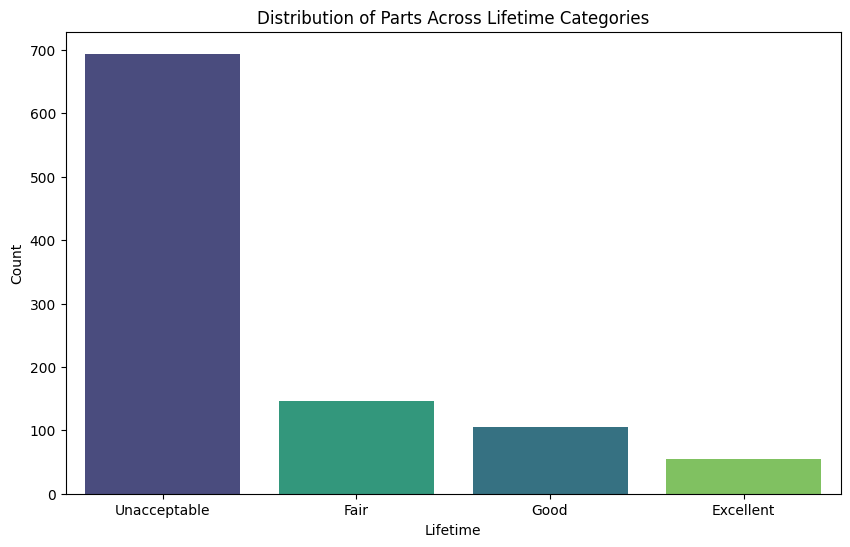

In [75]:
# Cell 9: Visualize the distribution of parts across Lifetime categories
plt.figure(figsize=(10, 6))
sns.countplot(
    x='Lifetime',
    data=clf_df,
    hue='Lifetime',
    order=cluster_ranges['Lifetime'].unique(),
    palette='viridis',
    dodge=False,
    legend=False
)
plt.xlabel('Lifetime')
plt.ylabel('Count')
plt.title('Distribution of Parts Across Lifetime Categories')
plt.show()

In [76]:
# Cell 10: Calculate the silhouette score
if len(acceptable_df['Lifetime'].unique()) > 1:
    # Map Lifetime labels back to cluster numbers for silhouette score
    label_to_cluster = {v: k for k, v in cluster_to_label.items()}
    acceptable_clusters = acceptable_df['Lifetime'].map(label_to_cluster)
    silhouette_avg = silhouette_score(X_acceptable, acceptable_clusters)
    print(f'Silhouette Score for k={elbow_k}: {silhouette_avg:.2f}')
else:
    print("Cannot compute silhouette score with only one cluster.")

Silhouette Score for k=3: 0.58


In [78]:
clf_df.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType,Lifetime
0,1469.17,Nozzle,equiGrain,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,Bottom,Die,Unacceptable
1,1793.64,Block,singleGrain,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,Bottom,Investment,Good
2,700.60,Blade,equiGrain,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,Bottom,Investment,Unacceptable
3,1082.10,Nozzle,colGrain,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,Top,Continuous,Unacceptable
4,1838.83,Blade,colGrain,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,Top,Die,Good
